In [2]:
#  Import the packages
from math import floor, ceil

import tensorflow as tf
tf.enable_eager_execution()
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import queue
import glob
import os
import json
from PIL import Image, ImageDraw
from shapely import wkt, geometry
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from tensorflow.python.keras.utils.data_utils import Sequence
from sklearn.model_selection import train_test_split

## Setting the Data Path

In [3]:
PATH_TO_DATASET = "D:\\Study\\X\\binet_AI\\nuit_de_IA_20190928\\train\\train\\"

In [88]:
SIZE_CUTS = 128              # size of the sub images extracted (in pixels)
SIZE_BUILDING_SEARCH = 32  # size of the granularity for building detection (should be smaller than SIZE_CUTS)

points_grid = [[geometry.Point(SIZE_BUILDING_SEARCH*i+SIZE_BUILDING_SEARCH//2, \
                SIZE_BUILDING_SEARCH*j+SIZE_BUILDING_SEARCH//2) \
                for j in range((2**10)//SIZE_BUILDING_SEARCH)] for i in range((2**10)//SIZE_BUILDING_SEARCH)]
all_points_grid = [[geometry.Point(i, j) for j in range(2**10)] for i in range(2**10)]

## Get the incident names

In [89]:
def get_incident_list():
    '''
    output: list of events id after disaster
    '''
    return [f[:-18] for f in os.listdir(PATH_TO_DATASET + "images\\") if 'post_disaster.png' in f]

list_incident = get_incident_list();

## Visualisation of Images

In [90]:
def show_img(img):
    plt.figure()
    plt.imshow(img)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [91]:
## Get Images

def get_image(incident_id, post):
    '''
    inputs: incident_id (string) : nom de la photo (exemple : hurricane-florence_00000044)
            post (booléen): True pour l'image après le désastre, False pour l'image avant
    output: numpy array 1024*1024*3
    '''
    post = "_post_disaster.png" if post else "_pre_disaster.png"
    fname = PATH_TO_DATASET + "images\\" + incident_id + post
    return np.array(Image.open(fname))

In [92]:
get_image(list_incident[0],0)

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [58, 81, 45],
        [47, 67, 35],
        [52, 72, 39]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [52, 75, 41],
        [57, 80, 43],
        [49, 71, 38]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [54, 78, 42],
        [48, 70, 36],
        [51, 73, 39]],

       ...,

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [45, 65, 38],
        [32, 51, 28],
        [34, 54, 29]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [52, 71, 42],
        [54, 76, 44],
        [43, 64, 34]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [57, 73, 42],
        [52, 71, 40],
        [68, 90, 52]]], dtype=uint8)

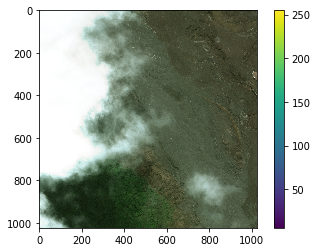

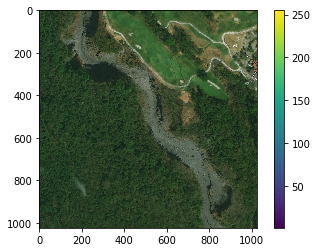

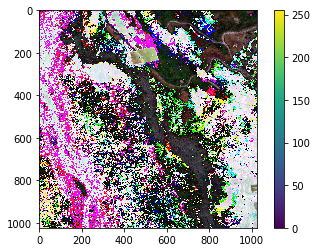

In [93]:
show_img(get_image(list_incident[2], 1))
show_img(get_image(list_incident[2], 0))
show_img(get_image(list_incident[2], 0) - get_image(list_incident[0], 1))

In [94]:
def get_label(incident_id, post):
    '''
    inputs: incident_id (string) : nom de la photo (exemple : hurricane-florence_00000044)
            post (booléen): True pour l'image après le désastre, False pour l'image avant
    output: dictionary:
                - "features" (properties of the image):
                    list of info for each building as dictionary:
                        - "uid" (string) id of the building
                        - "wkt" (list): list of the integer coordinates of the box for the building
                        - "damage" (int): 0 to 3 or -1, refer to the classification (only for post data)
                - "metadata": dictionary with
                    - "gsd" (ground sample distance)
                    - "off_nadir_angle"
                    - "sun_azimuth"
                    - "sun_elevation"
                    - "target_azimuth"
                    - "disaster"
                    - "disaster_type"
                    - "width"
                    - "height"
    '''
    postfixe = "_post_disaster.json" if post else "_pre_disaster.json"
    with open(PATH_TO_DATASET + "labels\\" + incident_id + postfixe) as json_file:
        data = json.load(json_file)
    
    data["features"] = data["features"]["xy"]
    for b in range(len(data["features"])):
        building = data["features"][b]
        building_filtered = {"uid": building["properties"]["uid"]}
        polygon = wkt.loads(building['wkt'])
        polygon = np.array(list(zip(polygon.exterior.coords.xy[1], polygon.exterior.coords.xy[0])))
        building_filtered["wkt"] = polygon
        if post:
            damage = {'destroyed':4, 'major-damage':3, 'minor-damage':2, 'no-damage':1, \
                      'un-classified':0}[building['properties']["subtype"]]
            building_filtered["damage"] = damage
        data["features"][b] = building_filtered
    
    # Filter available fields for the metadata
    metadataFields = ["gsd", "off_nadir_angle", "sun_aizmuth", "sun_elevation", "target_azimuth", \
                     "disaster", "disaster_type", "width", "height"]
#     data["metadata"] = {k:v for k,v in data["metadata"].items() if k in metadataFields}
    
    return data

In [95]:
def extract_images1(incident_id, post):
    '''
    inputs: img (Image object or np.array)
            post (booléen): True pour l'image après le désastre, False pour l'image avant
    output: list of pairs (sub images, damage) (length 2**20 / sizeCut^2, each sub image has size sizeCut*sizeCut)
    '''
    img = get_image(incident_id, post)
    labels = get_label(incident_id, post)
    buildings_labels = []
    for b in labels["features"]:
        if post:
            buildings_labels.append((b["wkt"], b["damage"]))
        else:
            buildings_labels.append((b["wkt"], 1))    
    
    # Detection of buildings
    number_division = 2**10//SIZE_BUILDING_SEARCH 
    buildings_array = np.zeros((number_division, number_division))
    for coordinates,l in buildings_labels :
        for x,y in coordinates :
            i,j = int(x // SIZE_BUILDING_SEARCH), int(y // SIZE_BUILDING_SEARCH)
            i,j = max(i,0), max(j,0)
            i,j = min(i,number_division-1),min(j,number_division-1)
            buildings_array[i,j] = 1
            
            
    # Extract subimages
    subImages = []
    fact = SIZE_CUTS//SIZE_BUILDING_SEARCH
    for i in range(2**10 // SIZE_CUTS):
        for j in range(2**10 // SIZE_CUTS):
            subImage = (img[i*SIZE_CUTS:(i+1)*SIZE_CUTS, j*SIZE_CUTS:(j+1)*SIZE_CUTS], buildings_array[i*fact:(i+1)*fact, j*fact:(j+1)*fact])
#             show_img(img[i*SIZE_CUTS:(i+1)*SIZE_CUTS, j*SIZE_CUTS:(j+1)*SIZE_CUTS])
#             print("building array: \n", buildings_array[i*fact:(i+1)*fact, j*fact:(j+1)*fact])
            subImages.append(subImage)
            
            
    return subImages

In [96]:
def get_image_colle(Incident_id):
    pre = get_image(Incident_id,False)
    post = get_image(Incident_id,True)
    return np.concatenate((pre,post),axis = 2)/255

In [97]:
def get_pixel_label(incident_id):
    '''
    return a 1024 * 1024 * 1 ndarray
    '''
    
    new_label = np.zeros((1024, 1024))
    with open(PATH_TO_DATASET + "labels\\" + incident_id + "_post_disaster.json") as json_file:
        data = json.load(json_file)
        data["features"] = data["features"]["xy"]
        for b in range(len(data["features"])):
            building = data["features"][b]
            damage = 'un-classified'
            if "subtype" in building["properties"]:
                damage = building["properties"]["subtype"]
            damage_dict = {'destroyed': 4, 'major-damage': 3, 'minor-damage': 2, 'no-damage': 1, 'un-classified': 0}
            damage = damage_dict[damage]
#             print(damage)
            polygon = wkt.loads(building['wkt'])
            polygon = np.array(list(zip(polygon.exterior.coords.xy[1], polygon.exterior.coords.xy[0])))
            b = polygon,
            zone = [(floor(b[0][:, 0].min()), floor(b[0][:, 1].min())),
                    (ceil(b[0][:, 0].max()), ceil(b[0][:, 1].max()))]
            for i in range(zone[1][0] - zone[0][0] ):
                for j in range(zone[1][1] - zone[0][1] ):
                    if geometry.Polygon(b[0]).contains(all_points_grid[zone[0][0] + i][zone[0][1] + j]):
                        new_label[zone[0][0]+i, zone[0][1]+j] = damage
    return new_label

In [98]:
SIZE_SKIP = 8;
SIZE_CUT = 128

In [99]:

def extract_images_pixel(incident_id):
    '''
    inputs: img (Image object or np.array)
    output: the subimages and a matrix of pixel label of same size;
    '''
    img = get_image_colle(incident_id)
    labels = get_pixel_label(incident_id)
    subImages = [];
    for i in range((1024-SIZE_CUT)//(SIZE_SKIP)+1):
        for j in range((1024-SIZE_CUT)//(SIZE_SKIP)+1):
            subImages.append((img[i*SIZE_SKIP:i*SIZE_SKIP+SIZE_CUTS, j*SIZE_SKIP:j*SIZE_SKIP+SIZE_CUTS], 
                              labels[i*SIZE_SKIP:i*SIZE_SKIP+SIZE_CUTS, j*SIZE_SKIP:j*SIZE_SKIP+SIZE_CUTS]))
    return subImages


In [101]:

def extract_images_max(incident_id):
    '''
    inputs: img (Image object or np.array)
    output: the subimages and a matrix of pixel label of same size;
    '''
    img = get_image_colle(incident_id)
    labels = get_pixel_label(incident_id)
    subImages = [];
    for i in range((1024-SIZE_CUT)//(SIZE_SKIP)+1):
        for j in range((1024-SIZE_CUT)//(SIZE_SKIP)+1):
            subImages.append((img[i*SIZE_SKIP:i*SIZE_SKIP+SIZE_CUTS, j*SIZE_SKIP:j*SIZE_SKIP+SIZE_CUTS], 
                              np.max(labels[i*SIZE_SKIP:i*SIZE_SKIP+SIZE_CUTS, j*SIZE_SKIP:j*SIZE_SKIP+SIZE_CUTS])))
    return subImages

# Model Images(Matrice) à Scalaire

In [102]:
class Dataset_generator_max(Sequence) :
    def __init__(self, ids, batch_size=16):
        self.ids = ids
        self.im_index = 0
        self.batch_size = batch_size
        self.sub_image_queue = queue.Queue()
        self.steps_per_epoch = (((1024-SIZE_CUT)//(SIZE_SKIP)+1)**2 * len(ids) ) // batch_size
    def get_next_images(self):
        
        for data in extract_images_max(self.ids[self.im_index]):
            self.sub_image_queue.put(data)
        self.im_index = (self.im_index + 1) % len(self.ids)
    
    def __len__(self) :
        return self.steps_per_epoch
    def get_item(self):
        x = []
        y = []
        if self.sub_image_queue.empty():
            self.get_next_images()
        image,label = self.sub_image_queue.get()
        return image, label

In [103]:
train_gen = Dataset_generator_max(list_incident[:])

In [104]:
train_set = []
train_label = []
TRAINING_SIZE = 2**12
for i in range(TRAINING_SIZE):
    t = train_gen.get_item()
    train_set.append(t[0]);
    train_label.append(t[1]);

In [105]:
train_set = np.array(train_set)
train_set = train_set.reshape(len(train_set), SIZE_CUT, SIZE_CUT, 6);
train_label = np.array(train_label)
train_label = train_label.reshape(len(train_label))

In [106]:
# Keras Model Building
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(SIZE_CUT, SIZE_CUT, 6)))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(5, activation='softmax'))

In [107]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 126, 126, 64)      3520      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               7372928   
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
__________

In [108]:
train_set.shape

(4096, 128, 128, 6)

In [109]:
train_label.shape

(4096,)

In [37]:
adam = tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [38]:
model.fit(train_set, train_label, shuffle = True, validation_split = 0.2 ,batch_size= 64, epochs=5)

Train on 3276 samples, validate on 820 samples
Epoch 1/5
3276/3276 [==============================] - 8s 3ms/sample - loss: 0.5644 - acc: 0.7973 - val_loss: 0.4675 - val_acc: 0.8037
Epoch 2/5
3276/3276 [==============================] - 7s 2ms/sample - loss: 0.3941 - acc: 0.8162 - val_loss: 0.3157 - val_acc: 0.8732
Epoch 3/5
3276/3276 [==============================] - 7s 2ms/sample - loss: 0.2667 - acc: 0.8800 - val_loss: 0.3428 - val_acc: 0.8634
Epoch 4/5
3276/3276 [==============================] - 7s 2ms/sample - loss: 0.1376 - acc: 0.9466 - val_loss: 0.2315 - val_acc: 0.9049
Epoch 5/5
3276/3276 [==============================] - 7s 2ms/sample - loss: 0.1356 - acc: 0.9509 - val_loss: 0.3527 - val_acc: 0.9037


# Model de Image à Matrice

In [41]:
class Dataset_generator_pixel(Sequence) :
    def __init__(self, ids, batch_size=16):
        self.ids = ids
        self.im_index = 0
        self.batch_size = batch_size
        self.sub_image_queue = queue.Queue()
        self.steps_per_epoch = (((1024-SIZE_CUT)//(SIZE_SKIP)+1)**2 * len(ids) ) // batch_size
    def get_next_images(self):
        
        for data in extract_images_pixel(self.ids[self.im_index]):
            self.sub_image_queue.put(data)
        self.im_index = (self.im_index + 1) % len(self.ids)
    
    def __len__(self) :
        return self.steps_per_epoch
    def get_item(self):
        x = []
        y = []
        if self.sub_image_queue.empty():
            self.get_next_images()
        image,label = self.sub_image_queue.get()
        return image, label

In [53]:
train_gen = Dataset_generator_pixel(list_incident[:])

In [54]:
train_set = []
train_label = []
TRAINING_SIZE = 2**12
for i in range(TRAINING_SIZE):
    t = train_gen.get_item()
    train_set.append(t[0]);
    train_label.append(t[1]);

In [57]:
train_set = np.array(train_set)
train_set = train_set.reshape(len(train_set), SIZE_CUT, SIZE_CUT, 6);
train_label = np.array(train_label)
train_label = train_label.reshape(len(train_label), SIZE_CUT, SIZE_CUT, 1)

In [75]:
# Keras Model Building

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(SIZE_CUT, SIZE_CUT, 6)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.Conv2DTranspose(64, (3, 3), activation='relu'))
model.add(keras.layers.Conv2DTranspose(filters = 5, kernel_size = (3,3), activation = "sigmoid"))


In [76]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 126, 126, 64)      3520      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 124, 124, 64)      36928     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 126, 126, 64)      36928     
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 128, 128, 5)       2885      
Total params: 80,261
Trainable params: 80,261
Non-trainable params: 0
_________________________________________________________________


In [77]:
adam = tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer= adam,
              loss='MSE',
              metrics=['accuracy'])

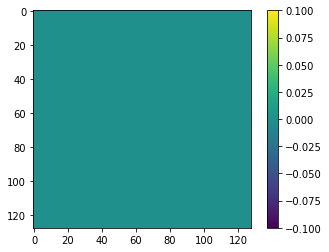

In [78]:
model.fit(train_set, train_label, shuffle = True, validation_split = 0.2 ,batch_size= 64, epochs=5)

Train on 3276 samples, validate on 820 samples
Epoch 1/5
3276/3276 [==============================] - 16s 5ms/sample - loss: 0.0526 - acc: 0.6400 - val_loss: 0.0043 - val_acc: 0.9503
Epoch 2/5
3276/3276 [==============================] - 16s 5ms/sample - loss: 0.0334 - acc: 0.9578 - val_loss: 0.0043 - val_acc: 0.9585
Epoch 3/5
3276/3276 [==============================] - 15s 5ms/sample - loss: 0.0334 - acc: 0.9648 - val_loss: 0.0042 - val_acc: 0.9649
Epoch 4/5
3276/3276 [==============================] - 15s 5ms/sample - loss: 0.0334 - acc: 0.9706 - val_loss: 0.0042 - val_acc: 0.9749
Epoch 5/5
3276/3276 [==============================] - 15s 5ms/sample - loss: 0.0334 - acc: 0.9794 - val_loss: 0.0042 - val_acc: 0.9787
